<a href="https://colab.research.google.com/github/Suryansh555/Pytorch/blob/main/MNIST_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1jFmGEBtgQJqQ5fOaxNVW5jZcG8C1KXE2')

# Image Classification with Logistic Regression (Minimal)

In [22]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet
!pip install jovian --upgrade --quiet

In [23]:
# Imports
import torch
import jovian
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [24]:
# Hyperparmeters
batch_size = 128
learning_rate = 0.001

# Other constants
input_size = 28*28
num_classes = 10

In [25]:
jovian.reset()
jovian.log_hyperparams(batch_size=batch_size, learning_rate=learning_rate)

[jovian] Hyperparams logged.


## Dataset & Data loaders

In [26]:
# Download dataset
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)

# Training validation & test dataset
train_ds, val_ds = random_split(dataset, [50000, 10000])
test_ds = MNIST(root='data/', train=False, transform=transforms.ToTensor())

# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

Label: 9


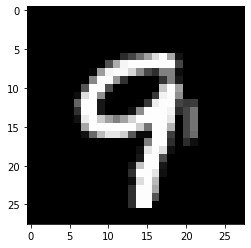

In [27]:
image, label = train_ds[0]
plt.imshow(image[0], cmap='gray')
print('Label:', label)

## Model

In [28]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

## Training

In [29]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [30]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [31]:
evaluate(model, val_loader)

{'val_acc': 0.12558594346046448, 'val_loss': 2.299773931503296}

In [71]:
history = fit(100, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.3326, val_acc: 0.9037
Epoch [1], val_loss: 0.3311, val_acc: 0.9035
Epoch [2], val_loss: 0.3296, val_acc: 0.9035
Epoch [3], val_loss: 0.3279, val_acc: 0.9043
Epoch [4], val_loss: 0.3266, val_acc: 0.9041
Epoch [5], val_loss: 0.3252, val_acc: 0.9045
Epoch [6], val_loss: 0.3239, val_acc: 0.9071
Epoch [7], val_loss: 0.3230, val_acc: 0.9064
Epoch [8], val_loss: 0.3213, val_acc: 0.9074
Epoch [9], val_loss: 0.3203, val_acc: 0.9079
Epoch [10], val_loss: 0.3190, val_acc: 0.9082
Epoch [11], val_loss: 0.3182, val_acc: 0.9086
Epoch [12], val_loss: 0.3170, val_acc: 0.9086
Epoch [13], val_loss: 0.3160, val_acc: 0.9089
Epoch [14], val_loss: 0.3151, val_acc: 0.9096
Epoch [15], val_loss: 0.3140, val_acc: 0.9092
Epoch [16], val_loss: 0.3133, val_acc: 0.9094
Epoch [17], val_loss: 0.3124, val_acc: 0.9100
Epoch [18], val_loss: 0.3115, val_acc: 0.9101
Epoch [19], val_loss: 0.3105, val_acc: 0.9109
Epoch [20], val_loss: 0.3098, val_acc: 0.9109
Epoch [21], val_loss: 0.3090, val_acc: 0.911

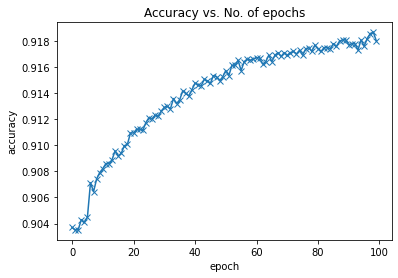

In [72]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [79]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_acc': 0.92236328125, 'val_loss': 0.277678906917572}

In [80]:
jovian.log_metrics(test_acc=result['val_acc'], test_loss=result['val_loss'])

[jovian] Metrics logged.


## Prediction

In [82]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 2 , Predicted: 2


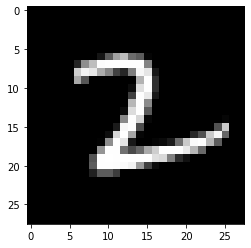

In [83]:
img, label = test_ds[919]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

## Save and upload

In [84]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

In [85]:
jovian.commit(project='mnist-logistic-minimal', environment=None, outputs=['mnist-logistic.pth'])
jovian.commit(project='mnist-logistic-minimal', environment=None, outputs=['mnist-logistic.pth']) # Kaggle commit fails sometimes, so try again..

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/suryansh-may/mnist-logistic-minimal
[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/suryansh-may/mnist-logistic-minimal


'https://jovian.ai/suryansh-may/mnist-logistic-minimal'